# Fun with Pillow and Matplotlib

Just a quick exploration to see if I can programmatically generate pixel graphs for use in my tricorder compass texture

## The Intent

I've created a custom item model of a tricorder, and I'd like it use it as a compass (or potentially a recover compass). The texture has a 9x10 area in which I can display a graph of some sort. I'd like that graph to be a peaked waveform where:
- at 0 degrees, it's a strongly peaked, almost delta function, centered at 0
- at 90 / 270 degrees, it's a flat line
- between 270 degrees and 90 degrees, it's a progressively weaker, progressively more off-center peak
- from 90 to 270 degrees, it's the vertically flipped image of 270 to 90

## 1. Creating a Pixelated Graph

Let's just start with a simple normal distribution, set our colors, and try downscaling it.

In [65]:
import io

import numpy as np
import scipy
from IPython.display import display
from matplotlib import pyplot as plt
from PIL import Image

_ = plt.ioff()

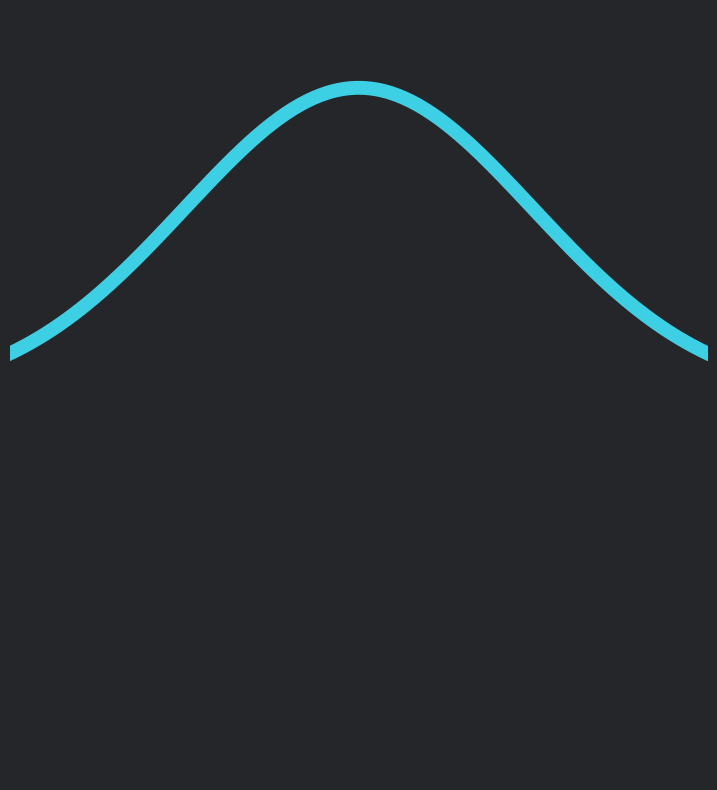

In [66]:
# cribbed from https://stackoverflow.com/questions/10138085/how-to-plot-normal-distribution
x = np.arange(-3, 3, 0.01)

fig, ax = plt.subplots(1, 1, figsize=(9, 10))
fig.set_facecolor("#24262a")
ax.set_axis_off()

ax.plot(x, scipy.stats.norm.pdf(x, 0, 0.5), color="#3dd0e5", linewidth=10)
ax.set_xbound(-1, 1)
ax.set_ybound(-1, 1)
plt.show()
plt.ioff()
_ = plt.close()

Well, I don't like the border, but I can trim that off.

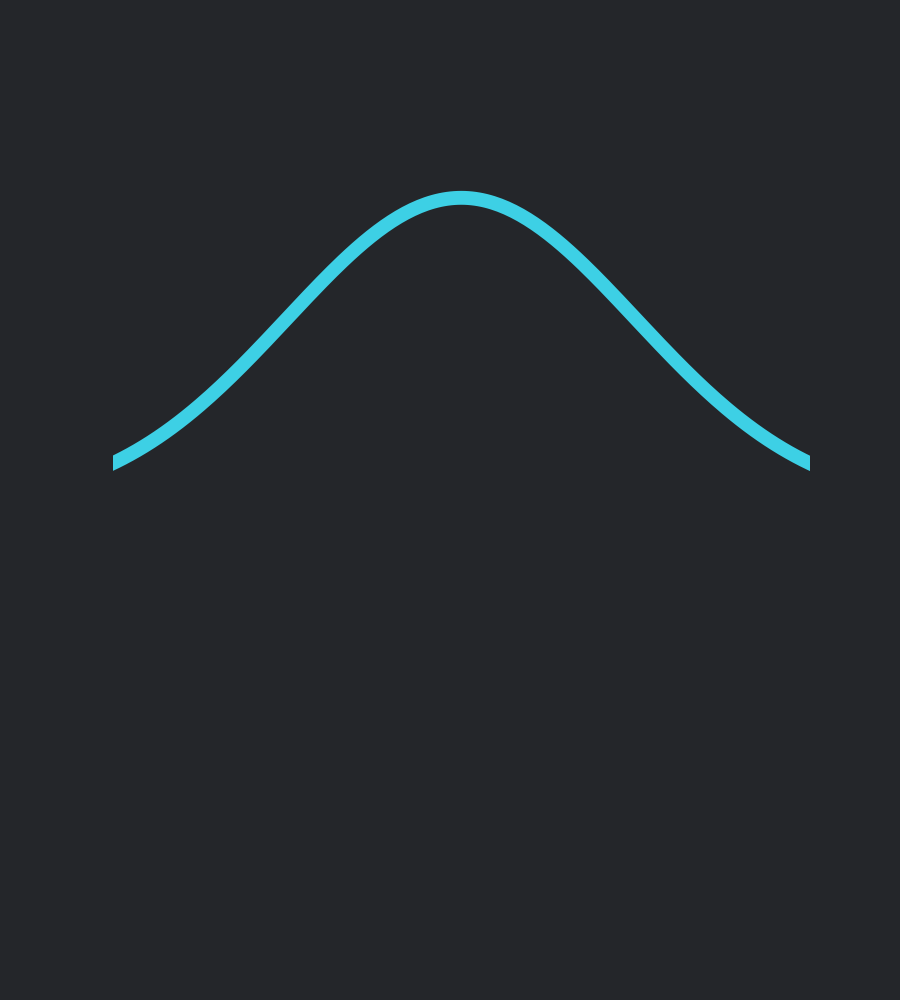

In [67]:
buffer = io.BytesIO()
fig.savefig(buffer)
buffer.seek(0)
img = Image.open(buffer)
display(img)

Okay, that border is ridiculous. And if I'm doing cropping, I want to make sure I have my bounds correct.

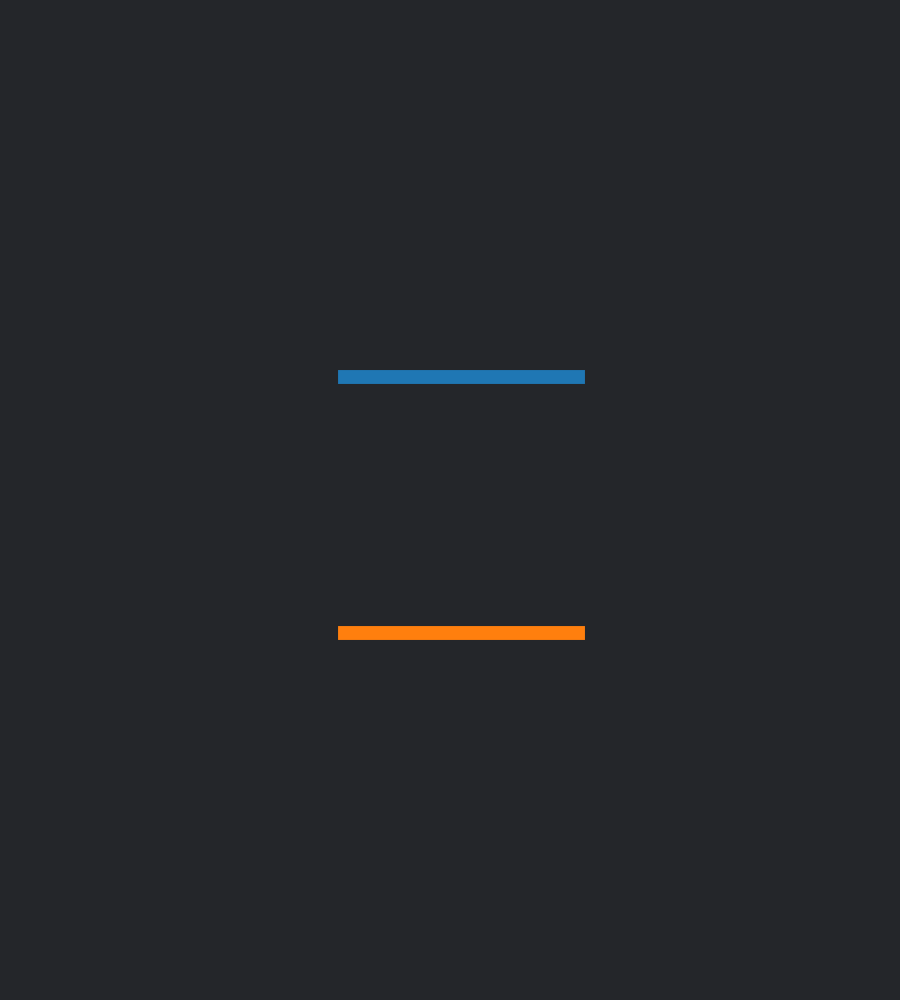

In [68]:
# cribbed from https://stackoverflow.com/questions/10138085/how-to-plot-normal-distribution
fig, ax = plt.subplots(1, 1, figsize=(9, 10))
fig.set_facecolor("#24262a")
ax.set_axis_off()
ax.plot([-1, 1], [1, 1], linewidth=10)
ax.plot([-1, 1], [-1, -1], linewidth=10)
ax.set_xbound(-3, 3)
ax.set_ybound(-3, 3)
buffer = io.BytesIO()
fig.savefig(buffer)
plt.close()
buffer.seek(0)
img = Image.open(buffer)
display(img)

In [69]:
img.size

(900, 1000)

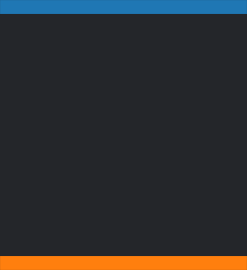

In [70]:
img.crop((338, 370, 585, 640))

Well that's random...

Now let's bring back our distribution and try rescaling it.

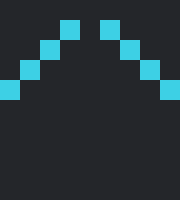

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(9, 10))
fig.set_facecolor("#24262a")
ax.set_axis_off()

ax.plot(x, scipy.stats.norm.pdf(x, 0, 0.5), color="#3dd0e5", linewidth=10)
ax.set_xbound(-3, 3)
ax.set_ybound(-3, 3)
buffer = io.BytesIO()
fig.savefig(buffer)
plt.close()
buffer.seek(0)
img = Image.open(buffer).crop((338, 370, 585, 640)).resize((9, 10), resample=0)
display(img.resize((180, 200), resample=0))

Not bad, just need to be a little more aggressive with my linewidth.

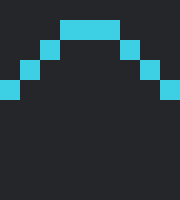

In [72]:
mu = 0
variance = 0.25
sigma = np.sqrt(variance)

fig, ax = plt.subplots(1, 1, figsize=(9, 10))
fig.set_facecolor("#24262a")
ax.set_axis_off()

ax.plot(x, scipy.stats.norm.pdf(x, 0, 0.5), color="#3dd0e5", linewidth=20)
ax.set_xbound(-3, 3)
ax.set_ybound(-3, 3)
buffer = io.BytesIO()
fig.savefig(buffer)
plt.close()
buffer.seek(0)
img = Image.open(buffer).crop((338, 370, 585, 640)).resize((9, 10), resample=0)
display(img.resize((180, 200), resample=0))

Okay, now let's try a super sharp distribution

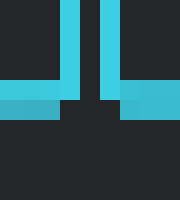

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(9, 10))
fig.set_facecolor("#24262a")
ax.set_axis_off()

ax.plot(x, scipy.stats.norm.pdf(x, 0, 0.1), color="#3dd0e5", linewidth=20)
ax.set_xbound(-3, 3)
ax.set_ybound(-3, 3)
buffer = io.BytesIO()
fig.savefig(buffer)
plt.close()
buffer.seek(0)
img = Image.open(buffer).crop((338, 370, 585, 640)).resize((9, 10), resample=0)
display(img.resize((180, 200), resample=0))

Now a shallow distribution

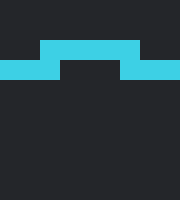

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(9, 10))
fig.set_facecolor("#24262a")
ax.set_axis_off()

ax.plot(x, scipy.stats.norm.pdf(x, 0, 0.8), color="#3dd0e5", linewidth=20)
ax.set_xbound(-3, 3)
ax.set_ybound(-3, 3)
buffer = io.BytesIO()
fig.savefig(buffer)
plt.close()
buffer.seek(0)
img = Image.open(buffer).crop((338, 370, 585, 640)).resize((9, 10), resample=0)
display(img.resize((180, 200), resample=0))

All right. I think this works. Now, while we don't technically _need_ the same number of frames as a compass, it will be much easier (I think) if stick with 32. So let's go ahead and generate our 00-08.

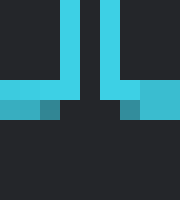

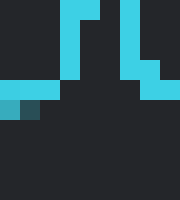

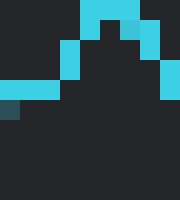

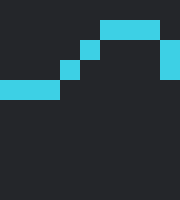

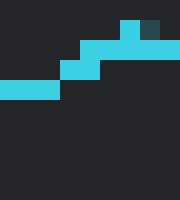

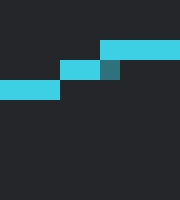

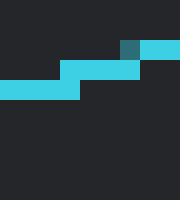

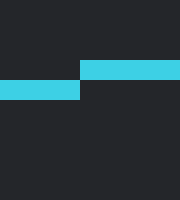

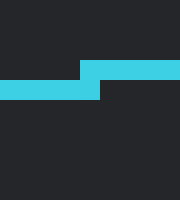

In [75]:
inlays = []
for i in range(9):
    fig, ax = plt.subplots(1, 1, figsize=(9, 10))
    fig.set_facecolor("#24262a")
    ax.set_axis_off()

    ax.plot(
        x,
        scipy.stats.norm.pdf(x, 1 / 7 * i, 0.125 * (i + 1)),
        color="#3dd0e5",
        linewidth=20,
    )
    ax.set_xbound(-3, 3)
    ax.set_ybound(-3, 3)
    buffer = io.BytesIO()
    fig.savefig(buffer)
    plt.close()
    buffer.seek(0)
    img = Image.open(buffer).crop((338, 370, 585, 640)).resize((9, 10), resample=0)
    inlays.append(img)
    display(img.resize((180, 200), resample=0))

## Compositing

So here's the basic texture. Unfortunately, the UV map is split up (and I'm too lazy to manually fix it), but at least the orientation is correct!

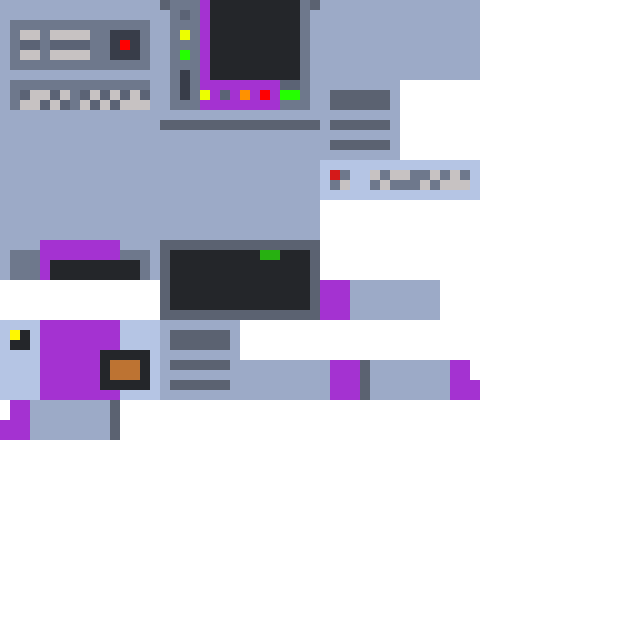

In [76]:
base = Image.open("../_static/tricorder.png")
display(base.resize((640, 640), resample=0))

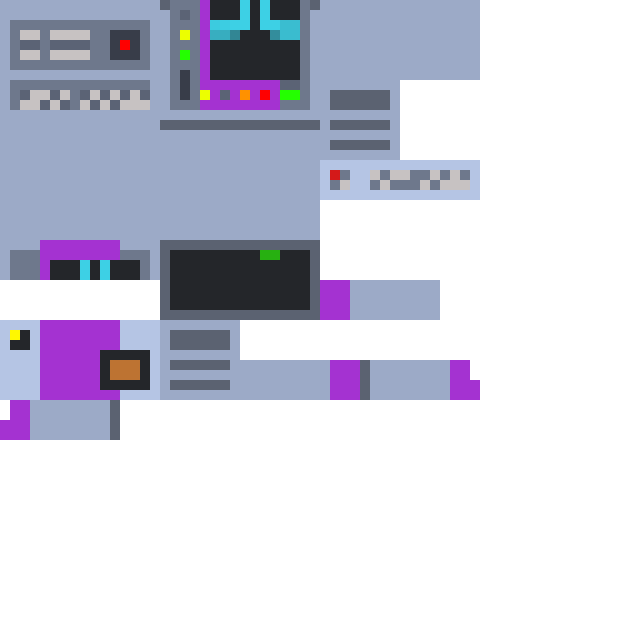

In [77]:
composited = Image.new("RGBA", (64, 64))
composited.paste(base, (0, 0))
composited.paste(inlays[0], (21, -2))
composited.paste(inlays[0].crop((0, 0, 9, 2)), (5, 26))
display(composited.resize((640, 640), resample=0))

And now mirroring

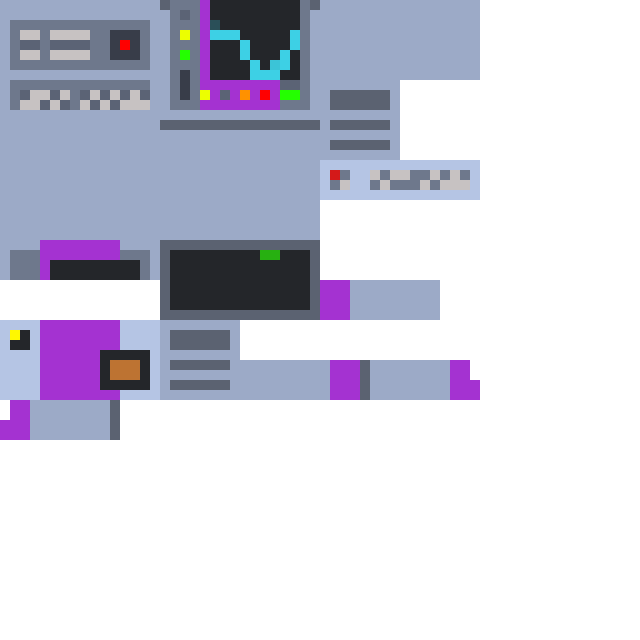

In [78]:
composited = Image.new("RGBA", (64, 64))
composited.paste(base, (0, 0))
composited.paste(inlays[2].transpose(Image.Transpose.FLIP_TOP_BOTTOM), (21, -2))
composited.paste(
    inlays[2].transpose(Image.Transpose.FLIP_TOP_BOTTOM).crop((0, 0, 9, 2)), (5, 26)
)
display(composited.resize((640, 640), resample=0))

Pillow really makes this easy! Let's go ahead and script it.

In [79]:
# it's so weird that compasses point south, but lodestone-facing is more important
for i in range(32):
    if i < 9:
        inlay = (
            inlays[i]
            .transpose(Image.Transpose.FLIP_TOP_BOTTOM)
            .transpose(Image.Transpose.FLIP_LEFT_RIGHT)
        )
    elif i < 16:
        inlay = inlays[16 - i].transpose(Image.Transpose.FLIP_LEFT_RIGHT)
    elif i < 24:
        inlay = inlays[i - 16]
    else:
        inlay = inlays[32 - i].transpose(Image.Transpose.FLIP_TOP_BOTTOM)
    composited = Image.new("RGBA", (64, 64))
    composited.paste(base, (0, 0))
    composited.paste(inlay, (21, -2))
    composited.paste(inlay.crop((0, 0, 9, 2)), (5, 26))
    composited.save(
        f"../../chappeau/Chappeau Resourcepack/assets/minecraft/textures/item/compass/tricorder_{i:02d}.png",
        format="png",
    )

## Creating the Item Model JSON

... while we're at it.

In [1]:
import copy
import json
from pathlib import Path

In [2]:
tricorder_folder = Path(
    "../../chappeau/Chappeau Resourcepack/assets/minecraft/models/item/tricorder"
)
tricorder_folder.mkdir(exist_ok=True)

In [10]:
for i in range(32):
    filename = f"tricorder_{i:02d}"
    (tricorder_folder / (filename + ".json")).write_text(
        json.dumps(
            {
                "parent": "item/custom/tricorder",
                "textures": {"0": f"item/compass/{filename}"},
            },
            indent=4,
            sort_keys=True,
        )
    )

In [7]:
compass_base = json.loads((Path("..") / "_static" / "compass_1_21.json").read_text())

In [8]:
for override in copy.deepcopy(compass_base["overrides"]):
    override["predicate"]["custom_model_data"] = 1701
    override["model"] = override["model"].replace("compass", "tricorder/tricorder")
    compass_base["overrides"].append(override)
Path(
    "../../chappeau/Chappeau Resourcepack/assets/minecraft/models/item/compass.json"
).write_text(json.dumps(compass_base, indent=4, sort_keys=True))

10889

### 1.21.4 Compat

No more "predicate" dict—the property is hard-coded as a separate field. But let's have a look at the new `compass.json`, which I've taken the liberty of simplifying for readibility:

In [59]:
compass_base = json.loads((Path("..") / "_static" / "compass_1_21_4.json").read_text())
compass_simplified = {
    k: v for k, v in compass_base["model"].items() if k not in ("on_false", "on_true")
}
for k in ("on_true", "on_false"):
    compass_simplified[k] = {
        k2: v
        for k2, v in compass_base["model"][k].items()
        if k2 not in ("entries", "cases", "fallback")
    }
    for k2 in ("entries", "cases"):
        if k2 in compass_base["model"][k]:
            compass_simplified[k][k2] = "..."
    if "fallback" in compass_base["model"][k]:
        compass_simplified[k]["fallback"] = {
            k3: v if k3 != "entries" else "..."
            for k3, v in compass_base["model"][k]["fallback"].items()
        }
display(compass_simplified)

{'type': 'minecraft:condition',
 'component': 'minecraft:lodestone_tracker',
 'property': 'minecraft:has_component',
 'on_true': {'type': 'minecraft:range_dispatch',
  'property': 'minecraft:compass',
  'scale': 32.0,
  'target': 'lodestone',
  'entries': '...'},
 'on_false': {'type': 'minecraft:select',
  'property': 'minecraft:context_dimension',
  'cases': '...',
  'fallback': {'type': 'minecraft:range_dispatch',
   'entries': '...',
   'property': 'minecraft:compass',
   'scale': 32.0,
   'target': 'none'}}}

So how multi-predicate conditions work now is that they're **nested**. Which means how we need to handle this is to add one more layer to the nesting.

In [60]:
def custom_item_check(compass_num: str) -> dict:
    """Replace the model type entry for
    a compass with a nested dict that first
    checks if it's a custom compass

    Parameters
    ----------
    compass_num : str
        The two digit number of the compass entry

    Returns
    -------
    dict
        The dict entry that's getting slotted in
    """
    return {
        "type": "range_dispatch",
        "property": "custom_model_data",
        "fallback": {
            "type": "model",
            "model": f"item/compass_{compass_num}",
        },
        "entries": [
            {
                "threshold": 1701,
                "model": {
                    "type": "model",
                    "model": f"item/tricorder/tricorder_{compass_num}",
                },
            }
        ],
    }

In [61]:
for entry in compass_base["model"]["on_true"]["entries"]:
    entry["model"] = custom_item_check(entry["model"]["model"][-2:])

In [62]:
for entry in compass_base["model"]["on_false"]["cases"][0]["model"]["entries"]:
    entry["model"] = custom_item_check(entry["model"]["model"][-2:])

In [63]:
for entry in compass_base["model"]["on_false"]["fallback"]["entries"]:
    entry["model"] = custom_item_check(entry["model"]["model"][-2:])

In [64]:
Path(
    "../../chappeau/Chappeau Resourcepack/assets/minecraft/items/compass.json"
).write_text(json.dumps(compass_base, indent=4, sort_keys=True))

88952